In [145]:
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
%matplotlib inline

import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression

from emoji_sentiment_tools_simple import get_sentiment_score_general
from sklearn.base import BaseEstimator, TransformerMixin

In [146]:
running_in_drive = False

images_path = '../presentation/Azin_images'
models_path = '../code/Azin_models'
data_path = '../data'


if running_in_drive:
    images_path = '/content/drive/MyDrive/GA/images'
    models_path = '/content/drive/MyDrive/GA/models'
    data_path = '/content/drive/MyDrive/GA/data'

In [148]:
!ls ../code/Azin_models

grid_CountVectorizer_MultinomialNB.pkl
grid_CountVectorizer_RandomForestClassifier.pkl
grid_TfidfVectorizer_LogisticRegression.pkl
mdl_CountVectorizer_LogisticRegression_TextSentimentizer.pkl
mdl_CountVectorizer_MultinomialNB.pkl
mdl_CountVectorizer_RandomForestClassifier.pkl
mdl_TfidfVectorizer_LogisticRegression.pkl


In [149]:
class TextSentimentizer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        SENT = X_.apply(lambda t: get_sentiment_score_general(t))
        d = pd.DataFrame(SENT)
        d.columns = ['SENT']
        return d
            
class NoSentimentizer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        SENT = X_.apply(lambda t: 0)
        d = pd.DataFrame(SENT)
        d.columns = ['SENT']
        return d     

In [159]:
def read_model(transformer, estimator, sentimentizer=None, t='grid', verbose=False):
    """
    Read the picked models.
    mdl = read_model('CountVectorizer', 'MultinomialNB')
    """
    name = f'{t}_{transformer}_{estimator}'
    if sentimentizer!=None:
        name = name + f'_{sentimentizer}'
    path = f'{models_path}/{name}.pkl'
    if verbose:
        print(f'Reading {path}:')
    with open(path, 'rb') as pickle_in:
        mdl = pickle.load(pickle_in)
    return mdl

def save_model(mdl, models_path, mdl_name):
  """
  Saves model into a pickle
  """
  # models_path = '/content/drive/MyDrive/GA/models'
  # mdl_name = 'test'
  mdl_path = f'{models_path}/{mdl_name}.pkl'


  with open(mdl_path, 'wb') as pickle_out:
      pickle_out = pickle.dump(mdl, pickle_out)

def read_data():
    """
    Reads the preprocessed data
    """
    
    path = f'{data_path}/processed_data.csv'
    df = pd.read_csv(path)
    df = df[['text', 'sentiment', 'Content Length', 'Content Word Count', 'emojis', 'num_comments','subreddit', 'label']]
    df.columns = df.columns.str.title()
    return df

def predict_label(mdl, text_input):
    labels = {1: 'Anxiety', 0: 'No Anxiety'}
    text_input_df = pd.DataFrame(text_input, columns=['Text'])
    try:
        out = mdl.predict(text_input_df.squeeze())
        pred = pd.DataFrame(out, columns=['prediction'])
        pred['text'] = text_input
        pred['prediction'] = pred['prediction'].map({1: 'Anxiety', 0: 'No Anxiety'})
        return pred[['text', 'prediction']]
    except Exception as e:
        out = mdl.predict(text_input_df)
        pred = pd.DataFrame(out, columns=['prediction'])
        pred['text'] = text_input
        pred['prediction'] = pred['prediction'].map({1: 'Anxiety', 0: 'No Anxiety'})
        return pred[['text', 'prediction']]
    
import re
def get_short(text):
    """
    Extracts the short string for estimators and transformers to be used in pipes.
    """
    if text is None:
        return None
    # https://stackoverflow.com/questions/1175208/elegant-python-function-to-convert-camelcase-to-snake-case
    pattern = re.compile(r'(?<!^)(?=[A-Z])')
    text = pattern.sub('_', text).lower()
    return ''.join([t[0] for t in text.split('_')])

In [152]:
rf_mdl = read_model('CountVectorizer', 'RandomForestClassifier')
mnb_mdl = read_model('CountVectorizer', 'MultinomialNB')
lr_mdl = read_model('TfidfVectorizer', 'LogisticRegression')
lr_sent_mdl = read_model('CountVectorizer', 'LogisticRegression', sentimentizer='TextSentimentizer', t='mdl')

In [154]:
text_input = ["I am sad", "writing", "I am anxious"]

print('\nMultinomialNB')
display(predict_label(mnb_mdl, text_input))
print('\nLogisticRegression')
display(predict_label(lr_mdl, text_input))

print('\nRandomForestClassifier')
display(predict_label(rf_mdl, text_input))

print('\nLogisticRegression Sent')
try:
    display(predict_label(lr_sent_mdl, text_input))
except Exception as e:
    print(e)


MultinomialNB


,text,prediction
0,I am sad,No Anxiety
1,writing,Anxiety
2,I am anxious,No Anxiety



LogisticRegression


,text,prediction
0,I am sad,Anxiety
1,writing,Anxiety
2,I am anxious,No Anxiety



RandomForestClassifier


,text,prediction
0,I am sad,No Anxiety
1,writing,No Anxiety
2,I am anxious,Anxiety



LogisticRegression Sent
'clean_text'


/Users/azin/opt/anaconda3/envs/ga/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


In [155]:
df = read_data()
df.head()

,Text,Sentiment,Content Length,Content Word Count,Emojis,Num_Comments,Subreddit,Label
0,dae question scared dying scared die anxiety c...,-0.9074,0,0,NaN,9,Anxiety,1
1,health tight throat tight throat gagging feeli...,-0.0516,51,10,NaN,1,Anxiety,1
2,advice needed anxiety overriding intuition. do...,0.8996,673,128,NaN,3,Anxiety,1
3,advice needed anxiety overriding intuition. do...,0.8996,673,128,NaN,7,Anxiety,1
4,advice needed hey friends! need advice anxiety...,-0.2338,405,82,NaN,1,Anxiety,1


In [156]:
df.groupby('Subreddit')['Num_Comments'].mean()

Subreddit
Anxiety       3.489667
No Anxiety    9.577333
Name: Num_Comments, dtype: float64

In [157]:
df.groupby('Subreddit')['Sentiment'].agg(['mean'])

,mean
Subreddit,
Anxiety,-0.282417
No Anxiety,0.267053


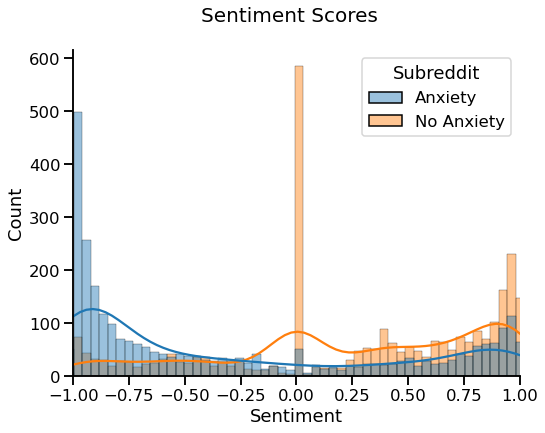

In [42]:
plt.figure(figsize=(8,6))
g = sns.histplot(df, x='Sentiment', hue='Subreddit', kde=True, legend=True, alpha=.45, bins=150);
sns.despine(top=True);
g.set_xlim(-1, 1)
plt.suptitle('Sentiment Scores', fontsize=20);
plt.savefig(f'{images_path}/sentiment_dist.png', bbox_inches='tight', dpi=300)

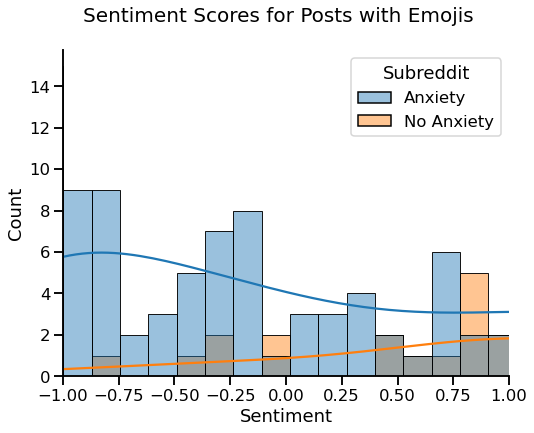

In [43]:
plt.figure(figsize=(8,6))
df_with_emojis = df[df['Emojis'].str.len()>0]
g = sns.histplot(df_with_emojis, x='Sentiment', hue='Subreddit', kde=True, legend=True, alpha=.45, bins=45);
sns.despine(top=True);
g.set_xlim(-1, 1)
plt.suptitle('Sentiment Scores for Posts with Emojis', fontsize=20);
plt.savefig(f'{images_path}/sentiment_dist_emoji.png', bbox_inches='tight', dpi=300)

In [44]:
df.fillna('', inplace=True)

#data = df.sample(n=1000, random_state=1)
data = df.copy()

X = data['Text']
y = data['Label']

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                            stratify=y, 
                                                            random_state=42)

In [46]:
X.shape

(6000,)

In [137]:
def make_roc_auc_curves(mdl, title):
    # ROC curve

    plt.style.use('fivethirtyeight')

    mdl.fit(X_train, y_train)
    plot_roc_curve(mdl, X_test, y_test)

    # add worst case scenario line
    plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")

    # add a legend
    plt.legend();

    def get_preds(probs, thres): # function takes probabilities and probability threshold
        return [0 if prob < thres else 1 for prob in probs] # Returns 0 if probability less than threshold
    # returns 1 if probability is above threshold


    # This would give the probability of belong to the positive class (1 or "dead")
    mdl.predict_proba(X_test)[:,1][0:5]

    # Changing the threshold to 10% (instead of the deafualt 50%)
    preds_10 = get_preds(mdl.predict_proba(X_test)[:, 1], thres=0.1)


    # Changing the threshold to 90% (instead of the deafualt 90%)
    preds_90 = get_preds(mdl.predict_proba(X_test)[:, 1], thres=0.9)

    plt.title(title);
    name = title.replace(' ', '_')
    plt.savefig(f'{images_path}/AUC_ROC_{name}.png', bbox_inches='tight', dpi=300)
    
def make_precision_recall_curve(mdl, title):
    
    preds = mdl.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, preds)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title(title);
    name = title.replace(' ', '_')
    plt.savefig(f'{images_path}/precision_recall_curve_{name}.png', bbox_inches='tight', dpi=300)

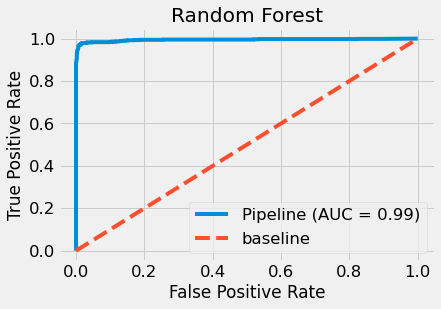

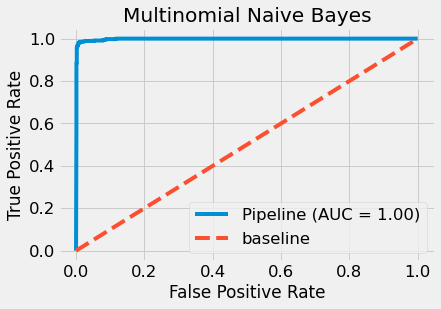

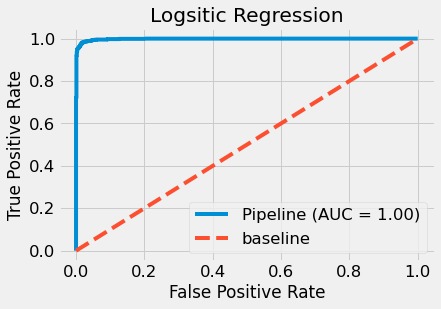

In [140]:
make_roc_auc_curves(rf_mdl.best_estimator_, 'Random Forest')
make_roc_auc_curves(mnb_mdl.best_estimator_, 'Multinomial Naive Bayes')
make_roc_auc_curves(lr_mdl.best_estimator_, 'Logsitic Regression')

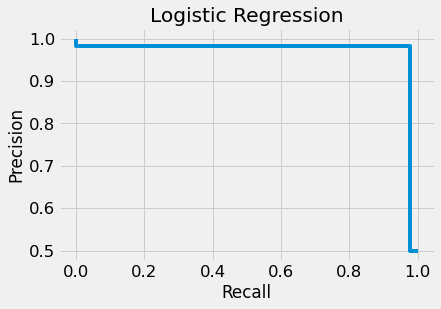

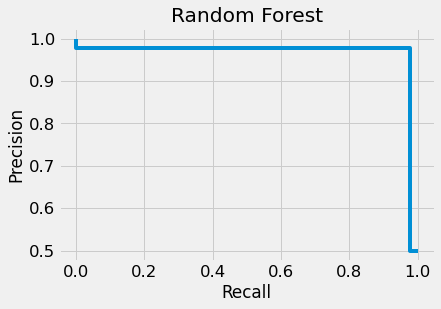

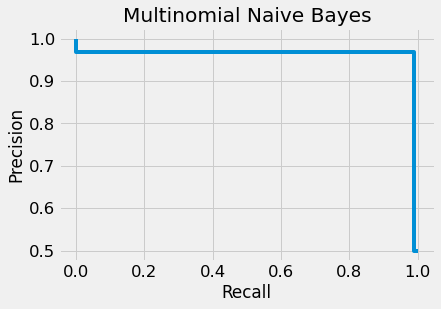

In [131]:
make_precision_recall_curve(lr_mdl, 'Logistic Regression')
make_precision_recall_curve(rf_mdl, 'Random Forest')
make_precision_recall_curve(mnb_mdl, 'Multinomial Naive Bayes')